In [1]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

In [2]:
#Python-related imports
import math, sys
from typing import Dict, Tuple, Union
from datetime import datetime
import os.path

#Torch-related imports
import torch
from torch.autograd import Function
from torch import nn
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim

#Module imports
from SBM_SDE_classes_multi_x_optim import *
from obs_and_flow import *
from training import *
from plotting import *
from mean_field import *
from TruncatedNormal import *
from LogitNormal import *

In [3]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.optimize import bisect

## Generate data

### Draw $\theta \sim p(\theta)$

In [34]:
seed = 2
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.333

#Parameter prior means
u_Q_ref_mean = 0.25
Q_mean = 0.001
a_MSA_mean = 0.5
K_DE_mean = 1000
K_UE_mean = 0.1
V_DE_ref_mean = 0.38
V_UE_ref_mean = 0.04
Ea_V_DE_mean = 55
Ea_V_UE_mean = 50
r_M_mean = 0.002
r_E_mean = 0.000024
r_L_mean = 0.000015
s_SOC_mean = 0.001
s_DOC_mean = 0.001
s_MBC_mean = 0.001
s_EEC_mean = 0.001

#SAWB-ECA theta truncated normal distribution parameter details in order of mean, sdev, lower, and upper.
u_Q_ref_details = torch.Tensor([u_Q_ref_mean, u_Q_ref_mean * prior_scale_factor, 0, 1])
Q_details = torch.Tensor([Q_mean, Q_mean * prior_scale_factor, 0, 1])
a_MSA_details = torch.Tensor([a_MSA_mean, a_MSA_mean * prior_scale_factor, 0, 1])
K_DE_details = torch.Tensor([K_DE_mean, K_DE_mean * prior_scale_factor, 0, 10000])
K_UE_details = torch.Tensor([K_UE_mean, K_UE_mean * prior_scale_factor, 0, 1])
V_DE_ref_details = torch.Tensor([V_DE_ref_mean, V_DE_ref_mean * prior_scale_factor, 0, 5])
V_UE_ref_details = torch.Tensor([V_UE_ref_mean, V_UE_ref_mean * prior_scale_factor, 0, 1])
Ea_V_DE_details = torch.Tensor([Ea_V_DE_mean, Ea_V_DE_mean * prior_scale_factor, 10, 150])
Ea_V_UE_details = torch.Tensor([Ea_V_UE_mean, Ea_V_UE_mean * prior_scale_factor, 10, 150])
r_M_details = torch.Tensor([r_M_mean, r_M_mean * prior_scale_factor, 0, 1])
r_E_details = torch.Tensor([r_E_mean, r_E_mean * prior_scale_factor, 0, 1])
r_L_details = torch.Tensor([r_L_mean, r_L_mean * prior_scale_factor, 0, 1])

#SAWB-ECA-SS diffusion matrix parameter distribution details
s_SOC_details = torch.Tensor([s_SOC_mean, s_SOC_mean * prior_scale_factor, 0, 1])
s_DOC_details = torch.Tensor([s_DOC_mean, s_DOC_mean * prior_scale_factor, 0, 1])
s_MBC_details = torch.Tensor([s_MBC_mean, s_MBC_mean * prior_scale_factor, 0, 1])
s_EEC_details = torch.Tensor([s_EEC_mean, s_EEC_mean * prior_scale_factor, 0, 1])

priors = {'u_Q_ref': u_Q_ref_details, 'Q': Q_details, 'a_MSA': a_MSA_details, 'K_DE': K_DE_details, 'K_UE': K_UE_details, 'V_DE_ref': V_DE_ref_details, 'V_UE_ref': V_UE_ref_details, 'Ea_V_DE': Ea_V_DE_details, 'Ea_V_UE': Ea_V_UE_details, 'r_M': r_M_details, 'r_E': r_E_details, 'r_L': r_L_details, 's_SOC': s_SOC_details, 's_DOC': s_DOC_details, 's_MBC': s_MBC_details, 's_EEC': s_EEC_details}

In [5]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    return x.stddev - target_sd

In [6]:
def sample_theta(priors):
    torch.manual_seed(0)
    scale_lower = 1e-8 #Lower bound for scale search by bisect function.
    scale_upper = 100 #Upper bound for scale search by bisect function. 
    
    theta_hyperparams = {} # hyperparams
    theta_samples = {} # theta samples
    for k, v in priors.items():
        sigmoid_loc, target_sd, a, b = v
        loc = logit(sigmoid_loc, a, b)
        scale = bisect(find_scale, scale_lower, scale_upper, (loc, a, b, target_sd))
        dist = RescaledLogitNormal(loc, scale, a, b)
        assert torch.abs(dist.stddev - target_sd) < 1e-4
        
        theta_hyperparams[k] = torch.tensor((loc, scale, a, b))
        theta_samples[k] = dist.sample()
        
    return theta_hyperparams, theta_samples

In [7]:
theta_hyperparams, theta_samples = sample_theta(priors)

In [8]:
theta_samples

{'u_Q_ref': tensor(0.3985),
 'Q': tensor(0.0009),
 'a_MSA': tensor(0.1643),
 'K_DE': tensor(1195.9664),
 'K_UE': tensor(0.0704),
 'V_DE_ref': tensor(0.2425),
 'V_UE_ref': tensor(0.0454),
 'Ea_V_DE': tensor(72.3682),
 'Ea_V_UE': tensor(38.8638),
 'r_M': tensor(0.0018),
 'r_E': tensor(1.8295e-05),
 'r_L': tensor(1.6622e-05),
 's_SOC': tensor(0.0008),
 's_DOC': tensor(0.0014),
 's_MBC': tensor(0.0007),
 's_EEC': tensor(0.0010)}

### Draw $x \sim p(x|\theta)$

In [9]:
num_sequences = 10
dt = 0.01
t = 5000
x0_SAWB_ECA = [65, 0.4, 2.5, 0.3]
x0_scale = 0.25

In [10]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON_multi(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Partition SOC, DOC, and MBC values.
    state_dim = 3
    SOC, DOC, MBC = torch.chunk(x, state_dim, 1)
    
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    
    #Evolve drift.
    drift_SOC = I_S + SCON_params_dict['a_DS'] * k_D * DOC + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * MBC - k_S * SOC
    drift_DOC = I_D + SCON_params_dict['a_SD'] * k_S * SOC + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * MBC - (SCON_params_dict['u_M'] + k_D) * DOC
    drift_MBC = SCON_params_dict['u_M'] * DOC - k_M * MBC
    
    return torch.cat([drift_SOC, drift_DOC, drift_MBC], 1)

def beta_SCON_C_multi(x, SCON_C_params_dict):
    b11 = torch.Tensor(SCON_C_params_dict['c_SOC'])
    b22 = torch.Tensor(SCON_C_params_dict['c_DOC'])
    b33 = torch.Tensor(SCON_C_params_dict['c_MBC'])
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33], 1)) 
    return b_matrix

def beta_SCON_SS_multi(x, SCON_SS_params_dict):
    state_dim = 3
    SOC, DOC, MBC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, and MBC values.
    b11 = torch.Tensor(SCON_SS_params_dict['s_SOC'] * SOC)
    b22 = torch.Tensor(SCON_SS_params_dict['s_DOC'] * DOC)
    b33 = torch.Tensor(SCON_SS_params_dict['s_MBC'] * MBC)
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33], 1)) 
    return b_matrix

def alpha_SAWB_multi(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Partition SOC, DOC, MBC, and EEC values.
    state_dim = 4
    SOC, DOC, MBC, EEC = torch.chunk(x, state_dim, 1)
    
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    
    #Evolve drift.
    drift_SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * MBC - ((V_D * EEC * SOC) / (SAWB_params_dict['K_D'] + SOC))
    drift_DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * MBC + ((V_D * EEC * SOC) / (SAWB_params_dict['K_D'] + SOC)) + SAWB_params_dict['r_L'] * EEC - ((V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + DOC))
    drift_MBC = (u_Q * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + DOC)) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * MBC
    drift_EEC = SAWB_params_dict['r_E'] * MBC - SAWB_params_dict['r_L'] * EEC
    
    return torch.cat([drift_SOC, drift_DOC, drift_MBC, drift_EEC], 1)

def beta_SAWB_C_multi(x, SAWB_C_params_dict):
    b11 = torch.Tensor(SAWB_C_params_dict['c_SOC'])
    b22 = torch.Tensor(SAWB_C_params_dict['c_DOC'])
    b33 = torch.Tensor(SAWB_C_params_dict['c_MBC'])
    b44 = torch.Tensor(SAWB_C_params_dict['c_EEC'])
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix

def beta_SAWB_SS_multi(x, SAWB_SS_params_dict):
    state_dim = 4
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, MBC, and EEC values.
    b11 = torch.Tensor(SAWB_SS_params_dict['s_SOC'] * SOC)
    b22 = torch.Tensor(SAWB_SS_params_dict['s_DOC'] * DOC)
    b33 = torch.Tensor(SAWB_SS_params_dict['s_MBC'] * MBC)
    b44 = torch.Tensor(SAWB_SS_params_dict['s_EEC'] * EEC)
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix

def alpha_SAWB_ECA_multi(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Partition SOC, DOC, MBC, and EEC values.
    state_dim = 4
    SOC, DOC, MBC, EEC = torch.chunk(x, state_dim, 1)
    
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    
    #Evolve drift.
    drift_SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * MBC - ((V_DE * EEC * SOC) / (SAWB_ECA_params_dict['K_DE'] + EEC + SOC))
    drift_DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * MBC + ((V_DE * EEC * SOC) / (SAWB_ECA_params_dict['K_DE'] + EEC + SOC)) + SAWB_ECA_params_dict['r_L'] * EEC - ((V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC))
    drift_MBC = (u_Q * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * MBC
    drift_EEC = SAWB_ECA_params_dict['r_E'] * MBC - SAWB_ECA_params_dict['r_L'] * EEC
    
    return torch.cat([drift_SOC, drift_DOC, drift_MBC, drift_EEC], 1)

def beta_SAWB_ECA_C_multi(x, SAWB_ECA_C_params_dict):
    b11 = torch.Tensor(SAWB_ECA_C_params_dict['c_SOC'])
    b22 = torch.Tensor(SAWB_ECA_C_params_dict['c_DOC'])
    b33 = torch.Tensor(SAWB_ECA_C_params_dict['c_MBC'])
    b44 = torch.Tensor(SAWB_ECA_C_params_dict['c_EEC'])
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix

def beta_SAWB_ECA_SS_multi(x, SAWB_ECA_SS_params_dict):
    state_dim = 4
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, MBC, and EEC values.
    b11 = torch.Tensor(SAWB_ECA_SS_params_dict['s_SOC'] * SOC)
    b22 = torch.Tensor(SAWB_ECA_SS_params_dict['s_DOC'] * DOC)
    b33 = torch.Tensor(SAWB_ECA_SS_params_dict['s_MBC'] * MBC)
    b44 = torch.Tensor(SAWB_ECA_SS_params_dict['s_EEC'] * EEC)
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix

In [11]:
def generate_x(BATCH_SIZE, ALPHA, BETA, X0_LOC, X0_SCALE, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, lower_bound = 1e-4):
    torch.manual_seed(seed)
    if ALPHA == alpha_SCON_multi:
        state_dim = 3
    elif ALPHA == alpha_SAWB_multi:
        state_dim = 4
    elif ALPHA == alpha_SAWB_ECA_multi:
        state_dim = 4
        
    N = int(T / DT) + 1
    x = torch.zeros([BATCH_SIZE, N, state_dim])
    
    # Draw initial condition x0
    X0_LOC = torch.as_tensor(X0_LOC)
    p_x0 = D.multivariate_normal.MultivariateNormal(loc = X0_LOC,
                                                    scale_tril = torch.diag(X0_LOC * X0_SCALE))
    #p_x0 = D.normal.Normal(loc = X0_LOC, scale = X0_LOC * X0_SCALE)
    x0_samples = p_x0.sample((BATCH_SIZE, )) # (batch_size, state_dim)
    x0_samples[x0_samples < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_samples = ', x0_samples)
    x[:, 0, :] = x0_samples
    
    # Vectorize variable calculations where possible
    hours = torch.tensor(np.linspace(0, T, N), dtype=torch.float) # 0
    I_S_tensor = I_S_FUNC(hours)
    I_D_tensor = I_D_FUNC(hours)
    temps = TEMP_FUNC(hours, TEMP_REF, TEMP_RISE)
    
    #Take Euler-Maruyama step. 
    for i in range(1, N):
        # Define x_i distribution
        a = ALPHA(x[:, i - 1, :], THETA_DICT, I_S_tensor[i], I_D_tensor[i], temps[i], TEMP_REF, arrhenius_temp_dep, linear_temp_dep)
        b = BETA(x[:, i - 1, :], THETA_DICT)
        p_x_i = D.multivariate_normal.MultivariateNormal(loc = x[:, i - 1, :] + a * DT, covariance_matrix = b * DT)
        
        # Draw sample
        x[:, i, :] = p_x_i.sample()        
        x[:, i, :][x[:, i, :] < lower_bound] = lower_bound #Bound all x above 0.
    
    return x, p_x0

In [12]:
t0 = time.time()
x, p_x0 = generate_x(num_sequences, alpha_SAWB_ECA_multi, beta_SAWB_ECA_SS_multi, x0_SAWB_ECA, x0_scale, t, dt, theta_samples, i_s, i_d, temp_gen, temp_ref, temp_rise)
print(x.shape, time.time() - t0)

X0_samples =  tensor([[46.7051,  0.2848,  2.3434,  0.2675],
        [78.7915,  0.4692,  2.3025,  0.1414],
        [70.2370,  0.2737,  2.7187,  0.3231],
        [66.9474,  0.5238,  3.1980,  0.2815],
        [43.0194,  0.2304,  2.8542,  0.3595],
        [74.7311,  0.2445,  2.2866,  0.4390],
        [61.4922,  0.3257,  2.8517,  0.3195],
        [62.1731,  0.3321,  3.0864,  0.3367],
        [84.5524,  0.4085,  1.7499,  0.2996],
        [56.5813,  0.3693,  1.5119,  0.4280]])
torch.Size([10, 500001, 4]) 426.69473814964294


In [35]:
t0 = time.time()
x, p_x0 = generate_x(num_sequences, alpha_SAWB_ECA_multi, beta_SAWB_ECA_SS_multi, x0_SAWB_ECA, x0_scale, t, dt, theta_samples, i_s, i_d, temp_gen, temp_ref, temp_rise)
print(x.shape, time.time() - t0)

X0_samples =  tensor([[48.08698273,  0.49166042,  1.68488097,  0.21677414],
        [45.19485474,  0.51675928,  1.83912992,  0.29108706],
        [50.24760437,  0.43452224,  2.14291620,  0.28236684],
        [81.37358093,  0.32471186,  2.35937548,  0.26754856],
        [40.50891113,  0.35414392,  1.96999955,  0.33949533],
        [65.48613739,  0.39501619,  3.16567373,  0.36645275],
        [50.92221832,  0.37343699,  2.60409069,  0.35933238],
        [78.91015625,  0.44094312,  1.78933978,  0.20974724],
        [60.13531113,  0.39350253,  1.51749408,  0.20091945],
        [47.98464584,  0.23971273,  3.18354201,  0.31270537]])
torch.Size([10, 500001, 4]) 414.60898995399475


## Inference

In [36]:
dt_flow = 1.0 # [1.0, 0.5]

In [37]:
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_printoptions(precision = 8)

#Neural SDE parameters
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]).to(active_device) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.

#Specify desired SBM SDE model type and details.
SBM_SDE_class = 'SAWB-ECA'
diffusion_type = 'SS'
theta_dist = 'RescaledLogitNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal'.
theta_post_dist = 'MultivariateLogitNormal'

#Generate exogenous input vectors.
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise).to(active_device)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor).to(active_device) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor).to(active_device) #Exogenous DOC input function

In [38]:
def calc_log_lik(C_PATH, PARAMS_DICT, DT, SBM_SDE_CLASS, INIT_PRIOR):
    # C_PATH.shape = (batch_size, num_sequences, n, state_dim)
    
    drift, diffusion_sqrt = SBM_SDE_CLASS.drift_diffusion(C_PATH, PARAMS_DICT)
    # drift.shape = (batch_size, num_sequences, N-1, state_dim)
    # diffusion.shape = (batch_size, num_sequences, N-1, state_dim, state_dim), or
    #                   (batch_size, num_sequences, 1, state_dim, state_dim) if diffusion type is C
    
    euler_maruyama_state_sample_object = D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT)) 

    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = euler_maruyama_state_sample_object.log_prob(C_PATH[:, :, 1:, :]).sum(-1) # log p(x|x0, theta), (batch_size, num_sequences)
    ll += INIT_PRIOR.log_prob(C_PATH[:, :, 0, :]) # log p(x0|theta)

    return ll # (batch_size, num_sequences)

def train(DEVICE, LR, NITER, BATCH_SIZE, X_ALL, T, DT, N,
          T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF,
          SBM_SDE_CLASS, DIFFUSION_TYPE, X0_PRIOR, PRIOR_DIST_DETAILS_DICT, 
          THETA_DIST = None, THETA_POST_DIST = None, THETA_POST_INIT = None,
          LR_DECAY = 0.8, DECAY_STEP_SIZE = 50000, PRINT_EVERY = 100):
    torch.manual_seed(seed)
    
    # Instantiate SBM_SDE object based on specified model and diffusion type.
    SBM_SDE_class_dict = {
            'SCON': SCON_multi,
            'SAWB': SAWB_multi,
            'SAWB-ECA': SAWB_ECA_multi
            }
    if SBM_SDE_CLASS not in SBM_SDE_class_dict:
        raise NotImplementedError('Other SBM SDEs aside from SCON, SAWB, and SAWB-ECA have not been implemented yet.')
    SBM_SDE_class = SBM_SDE_class_dict[SBM_SDE_CLASS]
    SBM_SDE = SBM_SDE_class(T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF, DIFFUSION_TYPE)

    # Load x, exclude CO2 and extra time steps 
    # (since data generation process uses smaller dt than dt_flow)
    #x_all = torch.load(X_FILE) # (num_sequences, all_time_steps, state_dim)
    step = (X_ALL.shape[1] - 1) // (N - 1)
    x = X_ALL[:, ::step, :SBM_SDE.state_dim] # (num_sequences, N, state_dim)
    x = x.unsqueeze(0) # (1, num_seqs, N, state_dim)
    #assert x.shape == (BATCH_SIZE, N, SBM_SDE.state_dim)

    # Convert prior details dictionary values to tensors.
    param_names = list(PRIOR_DIST_DETAILS_DICT.keys())
    prior_list = list(zip(*(PRIOR_DIST_DETAILS_DICT[k] for k in param_names))) #Unzip prior distribution details from dictionary values into individual lists.
    prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list).to(DEVICE) #Ensure conversion of lists into tensors.

    # Retrieve desired distribution class based on string.
    dist_class_dict = {
            'TruncatedNormal': TruncatedNormal,
            'RescaledLogitNormal': RescaledLogitNormal,
            'MultivariateLogitNormal': MultivariateLogitNormal
            }
    THETA_PRIOR_CLASS = dist_class_dict[THETA_DIST]
    THETA_POST_CLASS = dist_class_dict[THETA_POST_DIST] if THETA_POST_DIST else dist_class_dict[THETA_DIST]
    
    # Define prior
    p_theta = THETA_PRIOR_CLASS(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

    # Initialize posterior q(theta) using its prior p(theta)
    learn_cov = (THETA_POST_DIST == 'MultivariateLogitNormal')
    if THETA_POST_INIT is None:
        THETA_POST_INIT = PRIOR_DIST_DETAILS_DICT
    q_theta = MeanField(DEVICE, param_names, THETA_POST_INIT, THETA_POST_CLASS, learn_cov)

    #Record loss throughout training
    best_loss = 1e15
    losses = []

    #Initiate optimizers.
    optimizer = optim.Adamax(list(q_theta.parameters()), lr = LR)
    
    #Training loop
    with tqdm(total = NITER, desc = f'Learning SDE and hidden parameters.', position = -1) as tq:
        for it in range(1, NITER + 1):
            optimizer.zero_grad()                
            
            # Sample theta ~ q(theta) and compute log q(theta)
            theta_dict, theta, log_q_theta, _ = q_theta(BATCH_SIZE)
            
            # Compute log p(theta)
            log_p_theta = p_theta.log_prob(theta).sum(-1)

            # Compute log p(x|theta)
            log_lik = calc_log_lik(x, theta_dict, DT, SBM_SDE, X0_PRIOR).sum(-1) # (batch_size, num_sequences) -> (batch_size, )
            #print(log_lik.shape)

            # Compute negative ELBO: -(log p(theta) + log p(x|theta) - log q (theta))
            loss = -log_p_theta.mean() - log_lik.mean() + log_q_theta.mean()
            best_loss = loss if loss < best_loss else best_loss
            losses.append(loss.item())

            if it % PRINT_EVERY == 0:
                print('Iteration {} loss: {}'.format(it, loss))

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(ELBO_params, 5.0)
            optimizer.step()
        
            if it % DECAY_STEP_SIZE == 0:
                optimizer.param_groups[0]['lr'] *= LR_DECAY

            tq.update()
    
    return q_theta, p_theta, losses

In [39]:
#Training parameters
niter = 5000
train_lr = 0.05 #ELBO learning rate
batch_size = 40 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.

In [40]:
#Call training loop function for SCON-C.
t0 = time.time()
q_theta_raw, p_theta, losses = train(
        active_device, train_lr, niter, batch_size, x, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, p_x0, theta_hyperparams,
        THETA_DIST=theta_dist, THETA_POST_DIST=theta_post_dist,
        LR_DECAY = 1.0, PRINT_EVERY = niter // 10)
print(time.time() - t0)

Iteration 500 loss: -458266.78125
Iteration 1000 loss: -458461.03125
Iteration 1500 loss: -458578.03125
Iteration 2000 loss: -458672.71875
Iteration 2500 loss: -458750.5
Iteration 3000 loss: -458766.1875
Iteration 3500 loss: -458790.5625
Iteration 4000 loss: -458819.28125
Iteration 4500 loss: -458824.25
Iteration 5000 loss: -458834.5

8707.204606056213


In [41]:
#Call training loop function for SCON-C.
t0 = time.time()
q_theta_raw_mf, p_theta_mf, losses_mf = train(
        active_device, train_lr, niter, batch_size, x, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, p_x0, theta_hyperparams,
        THETA_DIST=theta_dist, THETA_POST_DIST=theta_dist,
        LR_DECAY = 1.0, PRINT_EVERY = niter // 10)
print(time.time() - t0)

Iteration 500 loss: -458243.625
Iteration 1000 loss: -458438.0625
Iteration 1500 loss: -458547.53125
Iteration 2000 loss: -458553.84375
Iteration 2500 loss: -458623.4375
Iteration 3000 loss: -458618.40625
Iteration 3500 loss: -458683.09375
Iteration 4000 loss: -458754.5
Iteration 4500 loss: -458796.03125
Iteration 5000 loss: -458832.21875

8667.120172023773


## Visualizations

In [20]:
def plot_loss(loss_hist_list, labels, time_hist_list=None, xscale='linear', yscale='linear',
              ymin=None, ymax=None, xmin=None, xmax=None):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (8, 6)})
    
    for loss_hist, label in zip(loss_hist_list, labels):
        plt.plot(loss_hist, label=label)
    
    plt.xlabel('iteration')
    plt.title('Loss v iteration')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))

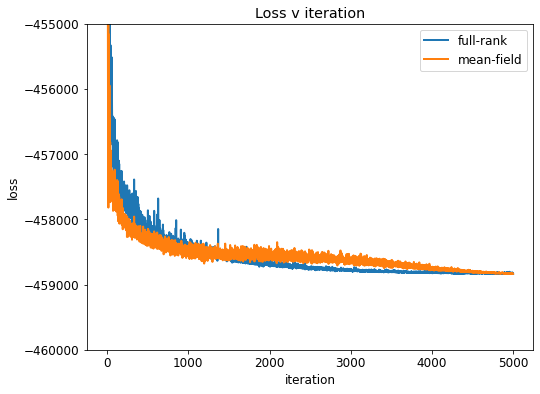

In [43]:
labels = ['full-rank', 'mean-field']
plot_loss([losses, losses_mf], labels, ymax=-455000, ymin=-460000) # 

In [25]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones_like(q.sds) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [44]:
q_theta = extract_dist(q_theta_raw)
q_theta_mf = extract_dist(q_theta_raw_mf)

In [27]:
def plot_theta(p_theta, q_theta_list, theta, labels, param_names, num_pts=1000, eps=1e-5, ncols=4,
               colors=None, linestyles=None, device=active_device):
    plt.rcParams.update({'font.size': 16, 'lines.linewidth': 2})
    
    # Load posterior and define plot boundaries
    a, b = p_theta.a, p_theta.b
    x0 = p_theta.mean - 4*p_theta.stddev
    x1 = p_theta.mean + 4*p_theta.stddev
    q_marginals = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, RescaledLogitNormal):
            q_marginal = q_theta
        else:
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        q_marginals.append(q_marginal)
        x0 = torch.fmin(x0, q_marginal.mean - 4*q_marginal.stddev)
        x1 = torch.fmax(x1, q_marginal.mean + 4*q_marginal.stddev)
        #print(x0, x1)
    x0 = torch.fmax(x0, a).detach()
    x1 = torch.fmin(x1, b).detach()
    x = torch.from_numpy(np.linspace(x0, x1, num_pts))
    
    # Load true theta
    #theta = torch.load(theta_file, map_location=device)
    
    # Compute pdfs
    #print(x[0, :], x[-1, :])
    prior_pdf = torch.exp(p_theta.log_prob(x)).detach()
    post_pdfs = []
    for q_theta in q_marginals:
        post_pdf = torch.exp(q_theta.log_prob(x)).detach()
        post_pdfs.append(post_pdf)
    
    # Plot prior v posterior v true theta
    num_params = len(param_names)
    nrows = int(num_params / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = np.atleast_2d(axes)
    k = 0
    if colors is None: colors = [cm.tab10(i+1) for i in range(len(post_pdfs))]
    if linestyles is None: linestyles = ['-'] * len(post_pdfs)
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            if k < num_params:
                key = param_names[k]
                ax.plot(x[:, k], prior_pdf[:, k], label='Prior $p(\\theta)$', color='tab:blue')
                for post_pdf, post_dist, c, l in zip(post_pdfs, labels, colors, linestyles):
                    label = 'Posterior $q(\\theta)$ {}'.format(post_dist)
                    ax.plot(x[:, k], post_pdf[:, k], label=label, color=c, linestyle=l)
                ax.axvline(theta[key], color='gray', label='True $\\theta$')
                ax.set_xlabel(key)
                if j == 0: ax.set_ylabel('density')
            elif k == num_params:
                handles, labels = axes[0, 0].get_legend_handles_labels()
                ax.legend(handles, labels, loc='center')
                ax.axis('off')
            else:
                fig.delaxes(axes[i, j])
            k += 1  
    plt.tight_layout()
    plt.suptitle('Marginal distributions')
    plt.subplots_adjust(top=0.95)
    plt.show()

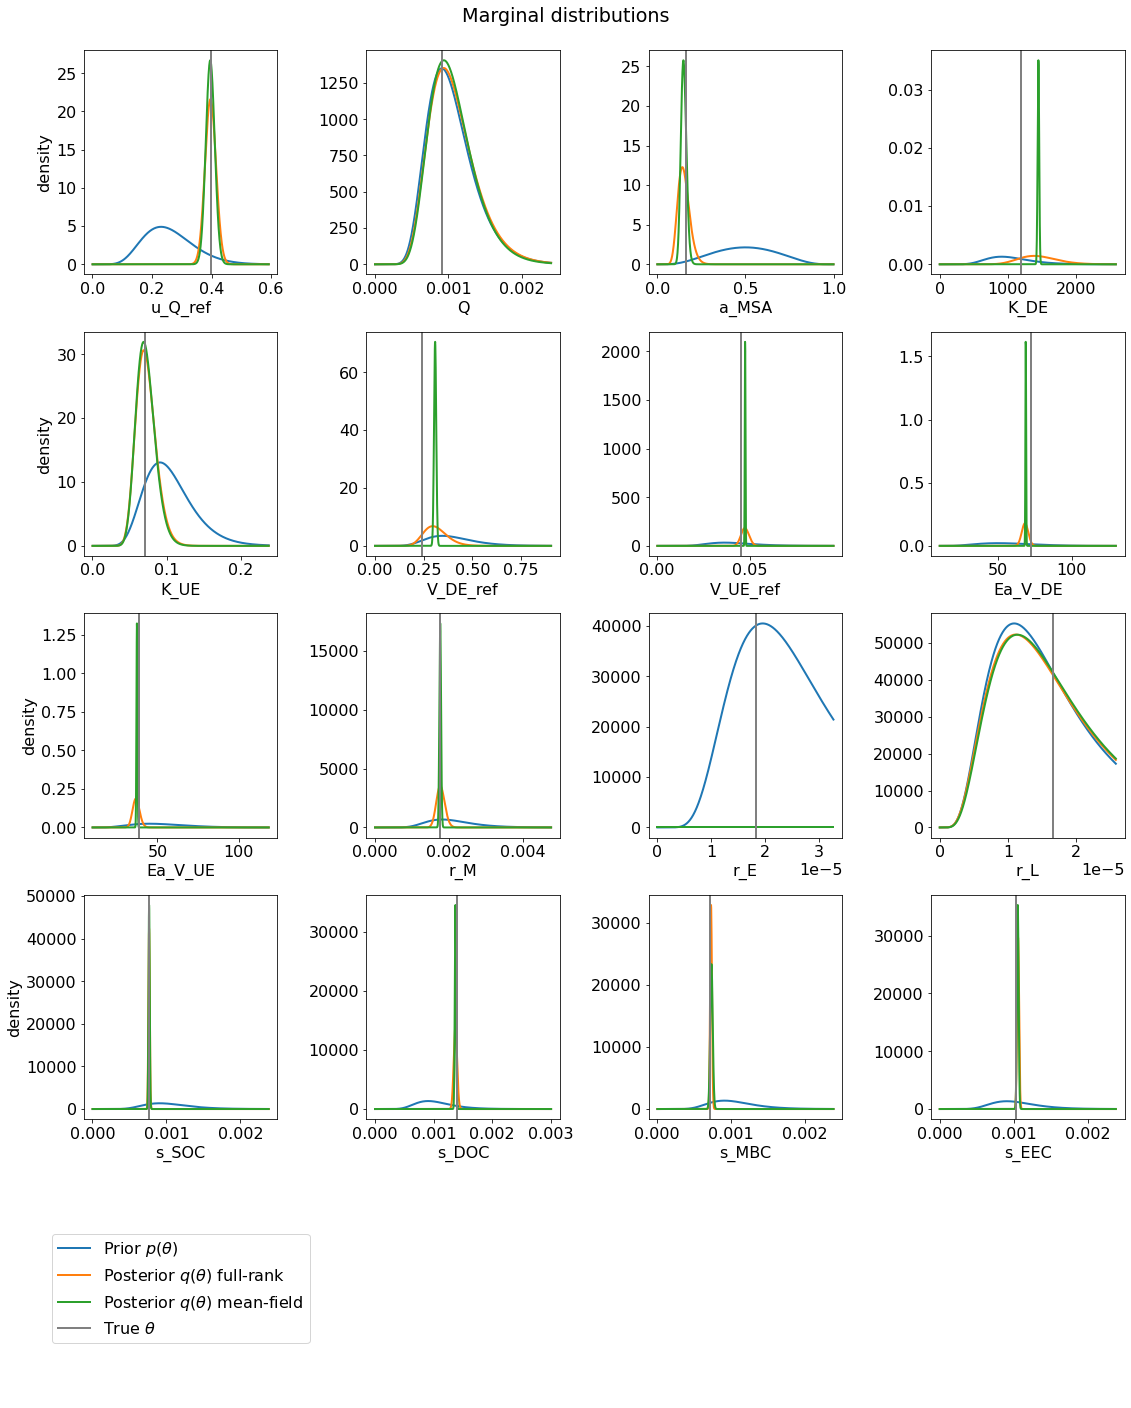

In [45]:
plot_theta(p_theta, [q_theta, q_theta_mf], theta_samples, labels, q_theta_raw.keys)

In [29]:
def plot_corr(q_theta_list, labels, param_names, num_samples=100000):
    plt.rcParams.update({'font.size': 12})
    
    # Calculate empirical correlation
    corr_list = []
    for q_theta in q_theta_list:
        assert isinstance(q_theta, MultivariateLogitNormal)
        samples = q_theta.sample((num_samples, )) # (N, D)
        corr_mc = np.corrcoef(samples.T)
        corr_list.append(corr_mc)
    
    # Plot
    num_cols = len(q_theta_list)
    fig, axes = plt.subplots(1, num_cols, figsize=(8*num_cols, 8))
    axes = np.atleast_1d(axes)
    D = len(q_theta_list[0].loc)
    
    for i, ax in enumerate(axes):
        plot = ax.imshow(corr_list[i], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_xticks(range(D))
        ax.set_xticklabels(param_names, rotation='vertical')
        ax.set_yticks(range(D))
        ax.set_yticklabels(param_names)
        ax.set_title(labels[i])
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.suptitle('Correlation between parameters')
    plt.show()

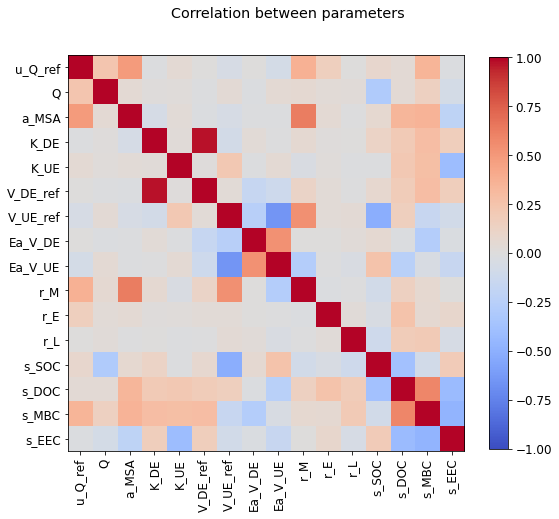

In [46]:
plot_corr([q_theta], [None], q_theta_raw.keys)

In [31]:
def plot_x(x, t_span, n):
    num_sequences, time_steps, state_dim = x.shape
    fig, axes = plt.subplots(state_dim, figsize=(15, 15))
    step = (x.shape[1] - 1) // (n - 1)
    x_plot = x[:, ::step, :state_dim]
    #print(x.shape, x_plot.shape)
    
    labels = ['SOC', 'DOC', 'MBC', 'EEC']
    for i, ax in enumerate(axes):
        for j in range(num_sequences):
            ax.plot(t_span, x_plot[j, :, i])
        ax.set_ylabel(labels[i])

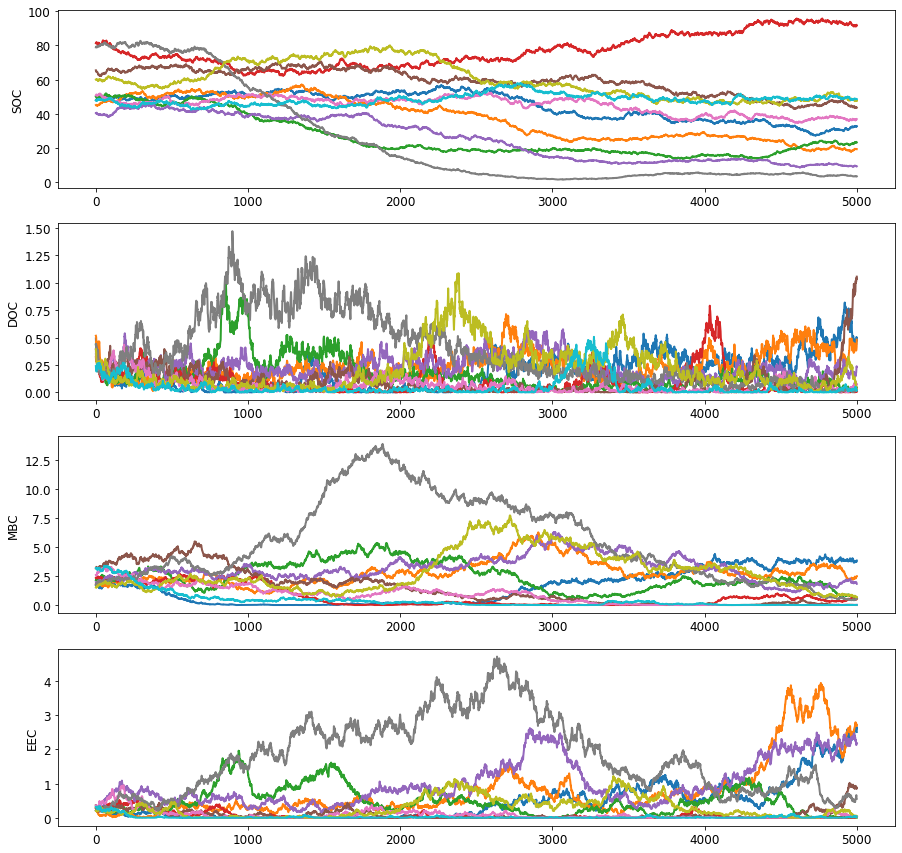

In [47]:
plot_x(x, t_span, n)

In [48]:
hyperparams_file = 'data/dt_1_t_5000_n_10/theta_from_multi_x_hyperparams_sawb_eca_ss_{}.pt'.format(seed)
theta_file = 'data/dt_1_t_5000_n_10/theta_from_multi_x_theta_sawb_eca_ss_{}.pt'.format(seed)
x_file = 'data/dt_1_t_5000_n_10/theta_from_multi_x_x_sawb_eca_ss_{}.pt'.format(seed)
q_file = 'data/dt_1_t_5000_n_10/theta_from_multi_x_q_sawb_eca_ss_{}.pt'.format(seed)
torch.save(theta_hyperparams, hyperparams_file)
torch.save(theta_samples, theta_file)
torch.save(x, x_file)
torch.save([q_theta, q_theta_mf], q_file)

## Compare with unobserved $x$

In [ ]:
q_theta_y_file = '../training_pt_outputs/q_theta_iter_310000_t_1000_dt_1.0_batch_40_layers_5_lr_0.0005_sd_scale_0.333_SCON-C_logit_multi_2021_09_22_11_48_46.pt'
q_theta_y_mf_file = '../training_pt_outputs/q_theta_iter_250000_t_1000_dt_1.0_batch_45_layers_5_lr_0.0005_sd_scale_0.333_SCON-C_no_CO2_logit_alt_2021_09_23_07_08_19.pt'
device=torch.device('cpu')
q_theta_y = extract_dist(torch.load(q_theta_y_file, map_location=device))
q_theta_y_mf = extract_dist(torch.load(q_theta_y_mf_file, map_location=device))

In [ ]:
theta_file = '../generated_data/SCON-C_CO2_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'
labels = ['full-rank, observe $y$', 'full-rank, observe $x$', 'mean-field, observe $y$', 'mean-field observe $x$']
plot_theta(p_theta, [q_theta_y, q_theta, q_theta_y_mf, q_theta_mf], theta_file, labels, q_theta_raw.keys,
           colors=[cm.tab10(1), cm.tab10(1), cm.tab10(2), cm.tab10(2)], linestyles=['-', '--', '-', '--'])

In [ ]:
plot_corr([q_theta_y, q_theta], ['Observe $y$', 'Observe $x$'], q_theta_raw.keys)

OMGGG I just realized `SBM_SDE` would need to change as well to support theta-from-multiple-x’s inference. We need to compute the negative ELBO:
$$\mathcal{L} = - \frac{1}{S} \sum_s \left[ \log p(\theta^{(s)}) + \log p(x|\theta^{(s)}) - \log q(\theta^{(s)}) \right]$$
where $S$ is the batch size.

With $M$ sequences of $x_i, i = 1, ..., M$, the log likelihood term is now:
$$\log p(x|\theta^{(s)}) = \sum_i \log p(x_i|\theta^{(s)})$$

So drift diffusion needs to take `C_PATH` of size `(S, M, N, D)` (currently `(S, N, D)`) and return a log likelihood tensor of size `(S, M)` (currently `(S, )`), where $N$ is the number of time steps and $D$ is the state dimensions.


In [ ]:
#(batch_size, 1, 1) 
diff1 = torch.arange(5).reshape((-1, 1, 1))
diff2 = torch.arange(5, 10).reshape((-1, 1, 1))
diff3 = torch.arange(10, 15).reshape((-1, 1, 1))
diff_list = [diff1, diff2, diff3]
diff_list

In [ ]:
tmp = 
tmp.shape

In [ ]:
diff_tensor = torch.diag_embed(torch.sqrt(LowerBound.apply(torch.cat(diff_list, 2), 1e-8))) # (batch_size, 1, state_dim, state_dim)
diff_tensor.shape

In [ ]:
diff_tensor[1] == torch.sqrt(torch.diag(torch.tensor([1, 6, 11])))

In [ ]:
(batch_size, N-1, state_dim)

In [ ]:
a = torch.randn(2, 3).reshape(2, 1, -1)
a.shape

In [ ]:
torch.diag_embed(a).shape

In [ ]:
a = torch.arange(12).reshape((2, 2, 3))
b = torch.arange(4).reshape((2, 2))

In [ ]:
a * b